#First approach
• Data preprocessing
• Input data as 1D array
• output data as array with one-hot encoding

In [1]:
#mayer mamdouh
#https://www.kaggle.com/mayermamdouh
from PIL import Image
import numpy as np
import pandas as pd
import os

df = pd.read_csv('train.csv')


imgs = []
ids = []
for i, row in df.iterrows():
    #os.path.join() method to construct the full path to the image file
    img_path = os.path.join('train/train/', row['Image']) 
    img = Image.open(img_path).convert('L') # Convert the image to grayscale ,because grayscale images have only one channel
    img = img.resize((100, 100)) # Resize image
    img = np.array(img) 
    imgs.append(img)
    ids.append(row['Id'])

#input data as 1D array
#  numpy arrays
X = np.array(imgs)
y = np.array(ids)



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   9850 non-null   object
 1   Id      9850 non-null   object
dtypes: object(2)
memory usage: 154.0+ KB


In [10]:
df.describe()

,Image,Id
count,9850,9850
unique,9850,4251
top,00022e1a.jpg,new_whale
freq,1,810


In [11]:
df2 = df.groupby('Id').agg('count').rename({'Image': 'Images'}, axis=1)
df2.sort_values('Images', ascending=False, inplace=True)
df2

,Images
Id,
new_whale,810
w_1287fbc,34
w_98baff9,27
w_7554f44,26
w_1eafe46,23
...,...
w_7e48479,1
w_7e728d8,1
w_7e8305f,1


In [12]:
num_images_per_id = df.groupby('Id')['Image'].nunique()
num_unique_ids = len(num_images_per_id)

print(f'Total number of unique whale IDs: {num_unique_ids}')
print(f'Number of images per ID:\n{num_images_per_id}')

Total number of unique whale IDs: 4251
Number of images per ID:
Id
new_whale    810
w_0013924      3
w_001ebbc      1
w_002222a      2
w_002b682      1
            ... 
w_ffb4e3d      2
w_ffbd74c      2
w_ffcd98e      2
w_ffda8b2      4
w_ffdab7a      1
Name: Image, Length: 4251, dtype: int64


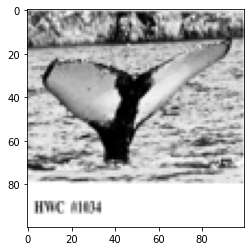

ID: w_e15442c


In [13]:
import matplotlib.pyplot as plt
for i in range(1):
    plt.imshow(X[i], cmap='gray')
    plt.show()
    print('ID:', y[i])

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)

y_encoded = encoder.transform(y)

print(y_encoded)

[3741  310 3613 ... 2337  746 3088]


In [15]:
# summary 
num_images = len(X)
num_unique_images = len(np.unique(X))
num_ids = len(y)
num_unique_ids = len(np.unique(y_encoded))

print(f'Total number of images: {num_images}')
print(f'Number of unique images: {num_unique_images}')
print(f'Total number of IDs: {num_ids}')
print(f'Total number of unique encoded IDs: {num_unique_ids}')

Total number of images: 9850
Number of unique images: 256
Total number of IDs: 9850
Total number of unique encoded IDs: 4251


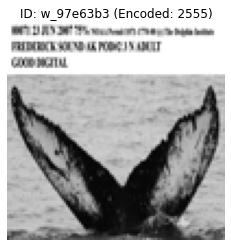

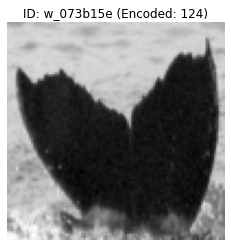

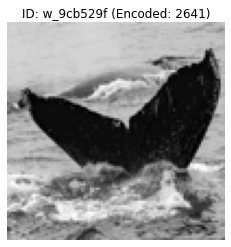

In [5]:
import matplotlib.pyplot as plt


random_indices = np.random.choice(len(X), size=3, replace=False)


for idx in random_indices:
    # Retrieve the image and its encoded ID
    img = X[idx]
    encoded_id = y_encoded[idx]
    
    # The encoded ID should be converted back to its original category value.
    original_id = encoder.inverse_transform([encoded_id])[0]
    
    
    plt.imshow(img, cmap='gray')
    plt.title(f'ID: {original_id} (Encoded: {encoded_id})')
    plt.axis('off')
    plt.show()


In [6]:
from sklearn.model_selection import train_test_split

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (7880, 100, 100)
Training labels shape: (7880,)
Testing data shape: (1970, 100, 100)
Testing labels shape: (1970,)


In [7]:
# Convert the target labels to one-hot to categorical
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_unique_ids)
y_test_encoded = to_categorical(y_test, num_unique_ids)


In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
model = Sequential()
#activation='relu' any value "-" make it 0 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1))) # 32 (3*3) filter (3*3*1+1)*32 this  "320 Param"
model.add(MaxPooling2D((2, 2))) # take max value from number of pixel , make feature more strong
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten()) #covert from 3D to 1D array , not import because already 1D not RGB to be 3D
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))# decrease  overfitting by off to some nurels 
model.add(Dense(num_unique_ids)) #num_unique_ids : number of classes


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-05-27 17:51:47.302012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [44]:


mayer2 = model.fit(X_train, y_train_encoded, batch_size=30, epochs=50, validation_data=(X_test, y_test_encoded), verbose=1)


loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


Epoch 1/50
263/263 [==============================] - 82s 311ms/step - loss: 7.7512 - accuracy: 0.0832 - val_loss: 8.1628 - val_accuracy: 0.0782
Epoch 2/50
263/263 [==============================] - 85s 322ms/step - loss: 7.6945 - accuracy: 0.0832 - val_loss: 8.2125 - val_accuracy: 0.0782
Epoch 3/50
263/263 [==============================] - 87s 331ms/step - loss: 7.6563 - accuracy: 0.0832 - val_loss: 8.2740 - val_accuracy: 0.0782
Epoch 4/50
263/263 [==============================] - 90s 344ms/step - loss: 7.5923 - accuracy: 0.0832 - val_loss: 8.2732 - val_accuracy: 0.0782
Epoch 5/50
263/263 [==============================] - 107s 407ms/step - loss: 7.5236 - accuracy: 0.0834 - val_loss: 8.3003 - val_accuracy: 0.0782
Epoch 6/50
263/263 [==============================] - 93s 354ms/step - loss: 7.4395 - accuracy: 0.0834 - val_loss: 8.3046 - val_accuracy: 0.0782
Epoch 7/50
263/263 [==============================] - 87s 332ms/step - loss: 7.3368 - accuracy: 0.0835 - val_loss: 8.3936 - val_a

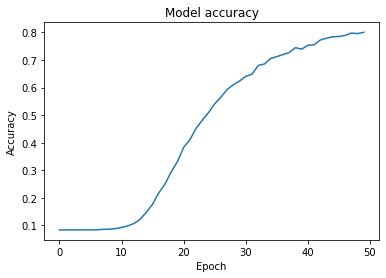

In [45]:
plt.plot(mayer2.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

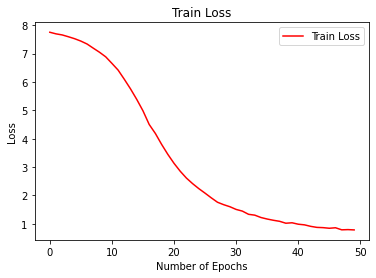

In [46]:
# Plot loss training
plt.plot(mayer2.history['loss'], color='r', label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [48]:
#training accuracy 
print('Train accuracy of the model: ',mayer2.history['accuracy'][-1])

Train accuracy of the model:  0.8008882999420166


In [49]:
#training loss 
print('Train loss of the model: ',mayer2.history['loss'][-1])

Train accuracy of the model:  0.7872496247291565


In [96]:
from PIL import Image
import numpy as np

def prepareImages(data, m, dataset):
    print("Preparing images")
    X = np.zeros((m, 100, 100, 1))
    
    for i, fig in enumerate(data['Image']):
        # Load images into images of size 100x100x1
        img_path = dataset + "/" + fig
        img = Image.open(img_path).convert('L')
        img = img.resize((100, 100))
        x = np.array(img)
        x = x.reshape(100, 100, 1)
        x = x / 255.0

        X[i] = x
        if (i % 500 == 0):
            print("Processing image:", i + 1, ",", fig)
    
    return X


In [99]:
import os
import pandas as pd
from tensorflow.keras.preprocessing import image

df_test = pd.DataFrame(os.listdir("test/test/"), columns=['Image'])
Test_Data = prepareImages(df_test, df_test.shape[0], "test/test")

Preparing images
Processing image: 1 , cb2aa96f.jpg
Processing image: 501 , 636e3758.jpg
Processing image: 1001 , 093774a1.jpg
Processing image: 1501 , 9c078425.jpg
Processing image: 2001 , e64104d9.jpg
Processing image: 2501 , 8d8843aa.jpg
Processing image: 3001 , f82cd2a7.jpg
Processing image: 3501 , 1763ba00.jpg
Processing image: 4001 , 46a63837.jpg
Processing image: 4501 , de4317ee.jpg
Processing image: 5001 , 129ef065.jpg
Processing image: 5501 , e85bf914.jpg
Processing image: 6001 , e5fe3dfc.jpg
Processing image: 6501 , 31af3ede.jpg
Processing image: 7001 , 130a830b.jpg
Processing image: 7501 , b6b8614f.jpg
Processing image: 8001 , e076af68.jpg
Processing image: 8501 , 5d035efa.jpg
Processing image: 9001 , d955f83d.jpg
Processing image: 9501 , 92d7ae60.jpg
Processing image: 10001 , bcf5e2f3.jpg
Processing image: 10501 , 56a932ea.jpg
Processing image: 11001 , c3da3791.jpg
Processing image: 11501 , 95def1fe.jpg
Processing image: 12001 , cda99e18.jpg
Processing image: 12501 , f21738

In [100]:
#predictions 
predictions = model.predict(np.array(Test_Data), verbose=1)

488/488 [==============================] - 51s 105ms/step


In [102]:
# assign the predicted to test dataframe
for i, pred in enumerate(predictions):
    df_test.loc[i, 'Id'] = ' '.join(encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [103]:
df_test.to_csv('Submission_Test.csv', index=False)